In [5]:
using ReinforcementLearning, ReinforcementLearningEnvironments, RLIntro.RandomWalk

In [7]:
using StatsBase, Plots

In [2]:
const N = 21

const true_values = -1:0.1:1

-1.0:0.1:1.0

In [15]:
Base.@kwdef struct RecordRMS <: AbstractHook
    rms::Vector{Float64}=[]
end

(h::RecordRMS)(::PostEpisodeStage, agent, env, obs) = push!(h.rms, sqrt(mean((agent.π.learner.approximator.table[2:end-1] - true_values[2:end-1]).^2)))


In [19]:
function create_agent_env(α, λ)
    env = RandomWalkEnv(N=21)
    ns, na =  length(observation_space(env)),  length(action_space(env))
    agent = Agent(
        π=VBasedPolicy(
            learner=TDλReturnLearner(
                approximator=TabularVApproximator(zeros(ns)),
                γ=1.0,
                α=α,
                λ=λ
            ),
            f = obs -> rand(1:na)
        ),
        buffer=episode_RTSA_buffer()
    )
    agent, env
end

function records(α, λ, nruns=10)
    rms = []
    for _ in 1:nruns
        hook = RecordRMS()
        run(create_agent_env(α, λ)..., StopAfterEpisode(10, is_show_progress=false);hook=hook)
        push!(rms, mean(hook.rms))
    end
    mean(rms)
end

records (generic function with 2 methods)

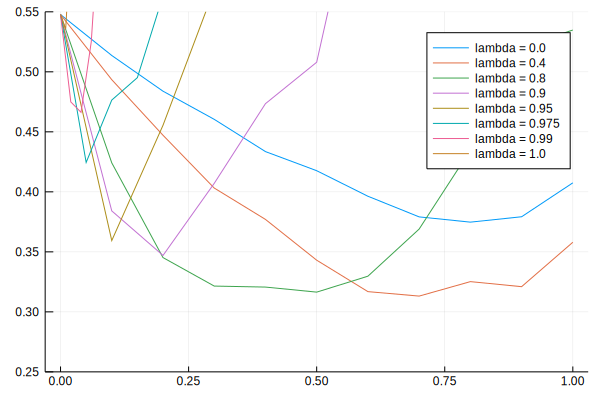

In [22]:
As = [0:0.1:1, 0:0.1:1, 0:0.1:1, 0:0.1:1, 0:0.1:1, 0:0.05:0.5, 0:0.02:0.2, 0:0.01:0.1]
Λ = [0., 0.4, .8, 0.9, 0.95, 0.975, 0.99, 1.]
p = plot(legend=:topright)
for (A, λ) in zip(As, Λ)
    plot!(p, A, [records(α, λ) for α in A], label="lambda = $λ")
end
ylims!(p, (0.25, 0.55))
p